# Define variable mappings for SDT analysis
Defines three dictionaries for selecting features relevant to SDT: competence, autonomy, and relatedness.

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

# Define paths
DATA_DIR = Path("../SDT_driven/data")
WVS7_PATH = DATA_DIR / "WVS7_Data_Imputed.csv"  # WVS 7 is pre-imputed by Miles
WVS6_PATH = DATA_DIR / "WVS6_Data.csv"
WVS5_PATH = DATA_DIR / "WVS5_Data.csv"

# Variable Mappings for SDT Analysis
WVS7_MAPPING = {
    "LifeSat": "Q49",
    "competence": {
        "Q47": "State of Health",
        "Q50": "Financial Satisfaction",
        "Q275": "Education",
        "Q285": "Chief Wage Earner",
        "Q286": "Family Savings",
        "Q287": "Subjective Social Class",
        "Q288": "Household Social Status",
    },
    "autonomy": {
        "Q48": "Freedom of Choice",
        "Q251": "Democracy",
        "Q253": "Human Rights",
        "Q209": "Petition",
        "Q210": "Boycott",
        "Q211": "Demonstration",
        "Q199": "Political Interest"
    },
    "relatedness": {
        "Q57": "Trust (General)",
        "Q58": "Trust in Family",
        "Q59": "Trust in Neighbors",
        "Q254": "National Pride",
        "Q1": "Importance of Family",
        "Q2": "Importance of Friends",
        "Q274": "Number of Children",
    },
}

WVS6_MAPPING = {
    "LifeSat": "V23",
    "competence": {
        "V11": "State of Health",
        "V59": "Financial Satisfaction",
        "V248": "Education",
        "V235": "Chief Wage Earner",
        "V237": "Family Savings",
        "V238": "Subjective Social Class",
        "V239": "Household Social Status",
    },
    "autonomy": {
        "V55": "Freedom of Choice",
        "V141": "Democracy",
        "V142": "Human Rights",
        "V85": "Petition",
        "V86": "Boycott",
        "V87": "Demonstration",
        "V84": "Political Interest",
    },
    "relatedness": {
        "V24": "Trust (General)",
        "V102": "Trust in Family",
        "V103": "Trust in Neighbors",
        "V211": "National Pride",
        "V4": "Importance of Family",
        "V5": "Importance of Friends",
        "V58": "Number of Children",
    },
}

WVS5_MAPPING = {
    "LifeSat": "V22",
    "competence": {
        "V11": "State of Health",
        "V68": "Financial Satisfaction",
        "V238": "Education",
        "V248": "Chief Wage Earner",
        "V251": "Family Savings",
        "V252": "Subjective Social Class",
        "V253": "Household Social Status",
    },
    "autonomy": {
        "V46": "Freedom of Choice",
        "V163": "Democracy",
        "V164": "Human Rights",
        "V96": "Petition",
        "V97": "Boycott",
        "V98": "Demonstration",
        "V95": "Political Interest",
    },
    "relatedness": {
        "V23": "Trust (General)",
        "V125": "Trust in Family",
        "V126": "Trust in Neighbors",
        "V209": "National Pride",
        "V4": "Importance of Family",
        "V5": "Importance of Friends",
        "V56": "Number of Children",
    },
}

# Data Loading and Subsetting

Define a function to load the dataset, select the relevant columns based on the mapping, and rename them to a standardized set of names.

In [2]:
def subset_wvs_data(file_path, mapping, wave_name):
    """
    Loads WVS data, subsets columns based on mapping, and renames them.
    """

    # Flatten the mapping to get a simple source -> target dictionary
    rename_map = {mapping["LifeSat"]: "LifeSat"}
    for category in ["competence", "autonomy", "relatedness"]:
        for source, target in mapping.get(category, {}).items():
            rename_map[source] = target
            
    cols_to_load = list(rename_map.keys())

    print(f"Loading {wave_name}...")
    df = pd.read_csv(file_path, usecols=cols_to_load)
    
    # Rename columns
    df = df.rename(columns=rename_map)
    
    print(f"Loaded {wave_name} with shape {df.shape}")
    return df

# Data Cleaning and Imputation

WVS data often uses negative numbers (e.g., -1, -2, -4, -5) to represent missing values (Don't know, No answer, etc.).
We will:
1. Replace these negative codes with `NaN`.
2. Impute missing values. We will use **Median Imputation** for this analysis.

In [3]:
from sklearn.impute import SimpleImputer

def clean_and_impute(df, wave_name):
    """
    Replaces negative values with NaN and imputes missing values using Median.
    """

    print(f"Cleaning {wave_name}...")
    
    # 1. Replace negative values with NaN
    # WVS codes: -1: Don't know, -2: No answer, -4: Not asked, -5: Missing
    # We assume any negative value is a missing code for these variables.
    df_clean = df.copy()
    for col in df_clean.columns:
        # Ensure numeric
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
        # Replace negatives
        df_clean.loc[df_clean[col] < 0, col] = np.nan
        
    missing_before = df_clean.isna().sum().sum()
    print(f"  Missing values before imputation: {missing_before}")
    
    # 2. Impute with Median
    imputer = SimpleImputer(strategy='median')
    df_imputed = pd.DataFrame(imputer.fit_transform(df_clean), columns=df_clean.columns)
    
    missing_after = df_imputed.isna().sum().sum()
    print(f"  Missing values after imputation: {missing_after}")
    
    return df_imputed

# Recoding Predictors

We need to ensure that higher values in the predictors correspond to higher levels of the construct (e.g., higher trust, better health).
Some variables in WVS are reverse-coded (e.g., 1 = Very Good, 4 = Very Poor). We will reverse these so that the direction is consistent.

We will define a list of variables to reverse for each wave.

In [4]:
def recode_variables(df, vars_to_reverse, vars_to_dummy, wave_name):
    """
    Reverses the scale of specified variables and applies dummy coding.
    """
    
    print(f"Recoding {wave_name}...")
    df_recoded = df.copy()
    
    # 1. Reverse Coding
    for column in vars_to_reverse:
        col_min = df_recoded[column].min()
        col_max = df_recoded[column].max()
        
        # Reverse code: new_val = min + max - old_val
        df_recoded[column] = col_min + col_max - df_recoded[column]

    print(f"  Reversed {len(vars_to_reverse)} variables.")
        
    # 2. Dummy Coding (2 -> 0, 1 -> 1)
    # Used for ChiefWageEarner and Trust
    for column in vars_to_dummy:
        df_recoded[column] = df_recoded[column].replace({2: 0})
        
    print(f"  Dummy coded {len(vars_to_dummy)} variables.")

    return df_recoded

# Variables to Reverse (Higher score = Higher construct level)
VARS_TO_REVERSE = [
    "State of Health", "Family Savings", "Subjective Social Class", "Human Rights", 
    "Petition", "Boycott", "Demonstration", "Political Interest", "Trust in Family", 
    "Trust in Neighbors", "National Pride", "Importance of Family", "Importance of Friends"
]

# Variables to Dummy Code (2 -> 0; 1 unchanged)
VARS_TO_DUMMY = [
    "Chief Wage Earner", "Trust (General)"
]

# Ordered Logit Analysis

We will run an Ordered Logit Model for each wave to identify the top predictors of Life Satisfaction.
We will standardize the predictors before running the model to compare effect sizes.


=== Processing WVS 7 ===
Loading WVS 7...
Loaded WVS 7 with shape (96614, 22)
Cleaning WVS 7...
  Missing values before imputation: 0
  Missing values after imputation: 0
Recoding WVS 7...
  Reversed 13 variables.
  Dummy coded 2 variables.
--- Running Ordered Logit for WVS 7 ---
                             OrderedModel Results                             
Dep. Variable:                LifeSat   Log-Likelihood:            -1.7233e+05
Model:                   OrderedModel   AIC:                         3.447e+05
Method:            Maximum Likelihood   BIC:                         3.450e+05
Date:                Tue, 09 Dec 2025                                         
Time:                        17:40:23                                         
No. Observations:               96614                                         
Df Residuals:                   96584                                         
Df Model:                          21                                         
       

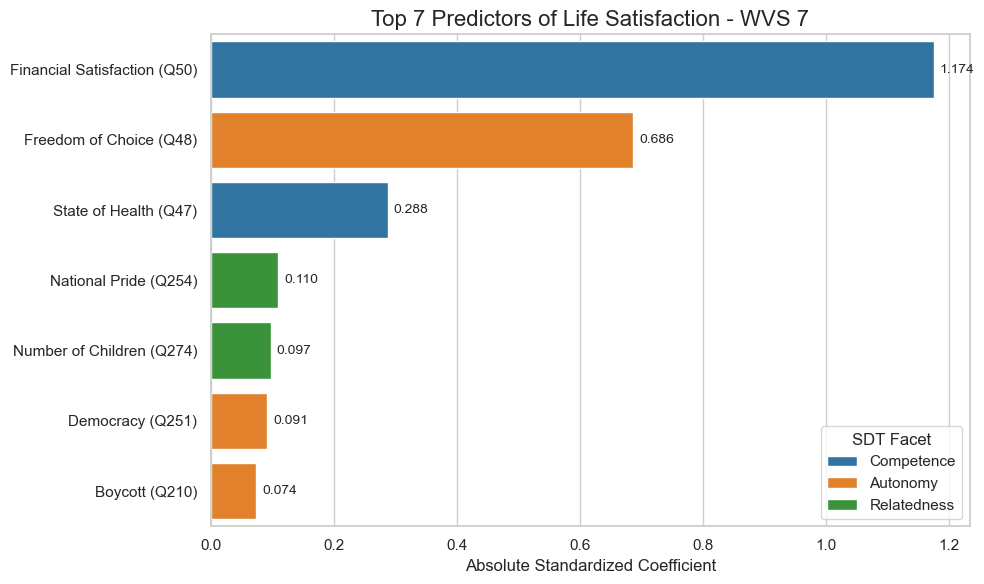


=== Processing WVS 6 ===
Loading WVS 6...
Loaded WVS 6 with shape (89565, 22)
Cleaning WVS 6...
  Missing values before imputation: 275889
  Missing values after imputation: 0
Recoding WVS 6...
  Reversed 13 variables.
  Dummy coded 2 variables.
--- Running Ordered Logit for WVS 6 ---
                             OrderedModel Results                             
Dep. Variable:                LifeSat   Log-Likelihood:                -58558.
Model:                   OrderedModel   AIC:                         1.172e+05
Method:            Maximum Likelihood   BIC:                         1.174e+05
Date:                Tue, 09 Dec 2025                                         
Time:                        17:40:32                                         
No. Observations:               89565                                         
Df Residuals:                   89543                                         
Df Model:                          21                                         
  

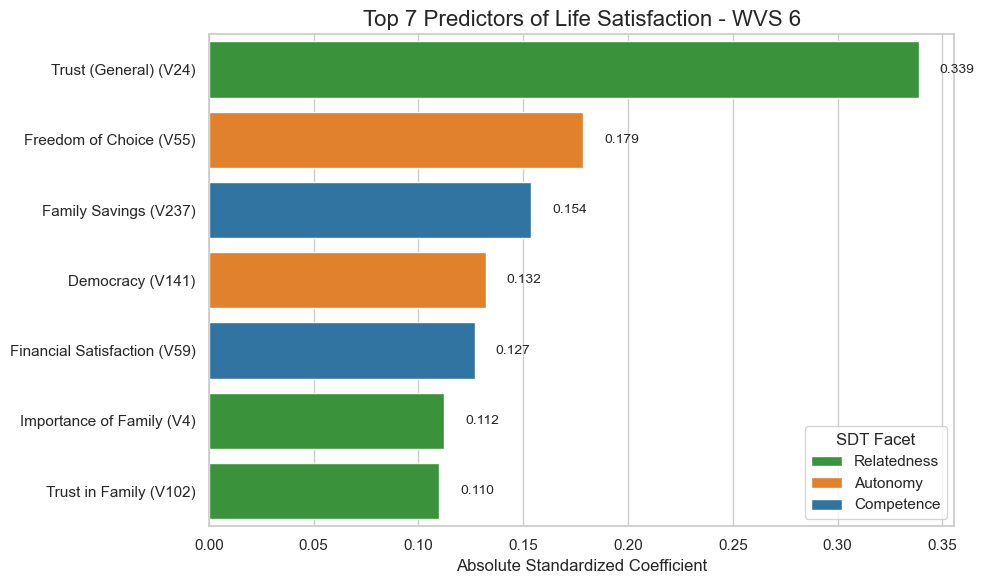


=== Processing WVS 5 ===
Loading WVS 5...
Loaded WVS 5 with shape (83975, 22)
Cleaning WVS 5...
  Missing values before imputation: 576012
  Missing values after imputation: 0
Recoding WVS 5...
  Reversed 13 variables.
  Dummy coded 2 variables.
--- Running Ordered Logit for WVS 5 ---
                             OrderedModel Results                             
Dep. Variable:                LifeSat   Log-Likelihood:                -7483.8
Model:                   OrderedModel   AIC:                         1.501e+04
Method:            Maximum Likelihood   BIC:                         1.522e+04
Date:                Tue, 09 Dec 2025                                         
Time:                        17:40:53                                         
No. Observations:               83975                                         
Df Residuals:                   83953                                         
Df Model:                          21                                         
  

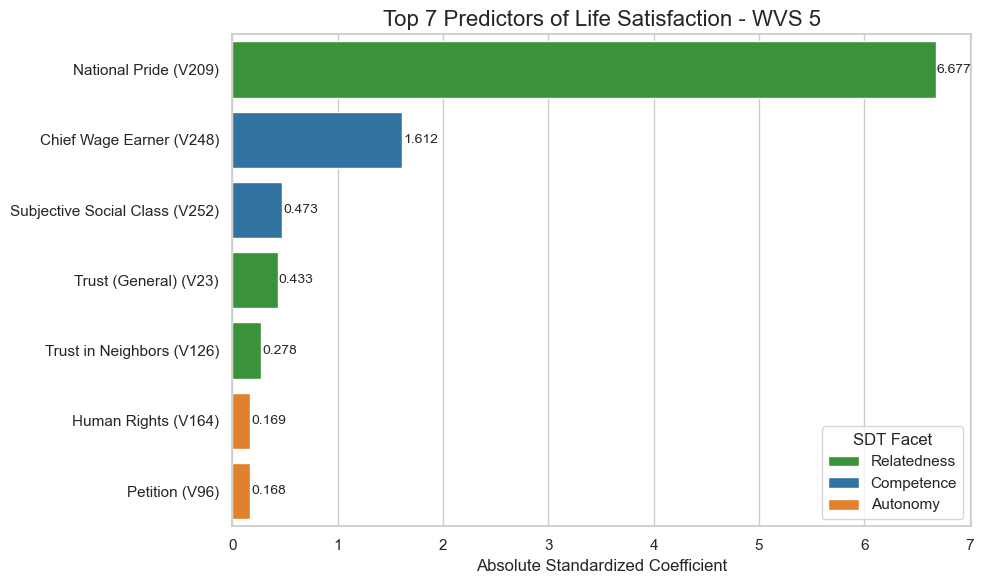

In [6]:
from statsmodels.miscmodels.ordinal_model import OrderedModel
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

def plot_top_predictors(coefs, wave_name, mapping):
    """
    Plots the top 7 predictors with their absolute standardized coefficients, 
    colored by SDT facet.
    """
    # Create a reverse mapping to find variable codes: Name -> Code
    name_to_code = {}
    name_to_category = {}

    # Map variable names to their categories
    for category in ["competence", "autonomy", "relatedness"]:
        for code, name in mapping.get(category, {}).items():
            name_to_code[name] = code
            name_to_category[name] = category.capitalize() 
            
    # Prepare data for plotting
    # coefs is a Series with index=Variable Name, value=Coefficient
    plot_data = coefs.to_frame(name='Coefficient')
    plot_data['AbsCoefficient'] = plot_data['Coefficient'].abs()
    plot_data = plot_data.sort_values('AbsCoefficient', ascending=False).head(7)
    
    # Create labels: "Variable Name (Code)"
    plot_data['Label'] = plot_data.index.map(lambda x: f"{x} ({name_to_code.get(x, 'N/A')})")
    
    # Assign SDT Facet
    plot_data['SDT Facet'] = plot_data.index.map(lambda x: name_to_category.get(x))

    # Define fixed palette for SDT facets
    sdt_colors = {
        "Competence": "#1f77b4",   
        "Autonomy": "#ff7f0e",     
        "Relatedness": "#2ca02c"
    }

    plt.figure(figsize=(10, 6))
    sns.set_theme(style="whitegrid")
    
    # Create bar plot
    ax = sns.barplot(
        x="AbsCoefficient", 
        y="Label", 
        data=plot_data, 
        hue="SDT Facet",
        palette=sdt_colors,
        dodge=False,
        orient='h'
    )
    
    plt.title(f"Top 7 Predictors of Life Satisfaction - {wave_name}", fontsize=16)
    plt.xlabel("Absolute Standardized Coefficient", fontsize=12)
    plt.ylabel("")
    plt.legend(title="SDT Facet", loc='lower right')
    
    # Add value labels to the right of the bars
    for i, v in enumerate(plot_data['AbsCoefficient']):
        ax.text(v + 0.01, i, f"{v:.3f}", va='center', fontsize=10)
        
    plt.tight_layout()
    
    # Save plot
    output_path = Path("../SDT_driven/output") / f"top_predictors_{wave_name.replace(' ', '_')}.png"
    output_path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"Plot saved to {output_path}")
    plt.show()

def run_ordered_logit(df, wave_name, mapping):
    """
    Runs Ordered Logit Model and displays results.
    """

    print(f"--- Running Ordered Logit for {wave_name} ---")
    
    # Prepare data
    target_col = "LifeSat"
    predictor_cols = [c for c in df.columns if c != target_col]
    df_model = df[predictor_cols + [target_col]]
    
    X = df_model[predictor_cols]
    y = df_model[target_col].astype(int)
    
    # Standardize predictors
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=predictor_cols, index=X.index)
    
    # Fit model
    try:
        model = OrderedModel(y, X_scaled, distr='logit')
        res = model.fit(method='bfgs', disp=False, maxiter=200)
        
        print(res.summary())
        
        # Extract and display top predictors
        params = res.params
        # Filter out threshold parameters
        # In statsmodels OrderedModel, thresholds are at the end.
        # We can assume predictors are the first N parameters where N is number of columns in X
        coefs = params.iloc[:len(predictor_cols)]
        
        top_predictors = coefs.abs().sort_values(ascending=False).head(10)
        print("\nTop 10 Predictors (by absolute standardized coefficient):")
        print(top_predictors)
        
        # Plot top 7
        plot_top_predictors(coefs, wave_name, mapping)
        
    except Exception as e:
        print(f"Error running model for {wave_name}: {e}")

# Main Execution Block
def run_analysis_pipeline():
    # 1. WVS 7
    print("\n=== Processing WVS 7 ===")
    df7 = subset_wvs_data(WVS7_PATH, WVS7_MAPPING, "WVS 7")
    df7 = clean_and_impute(df7, "WVS 7") 
    df7 = recode_variables(df7, VARS_TO_REVERSE, VARS_TO_DUMMY, "WVS 7")
    run_ordered_logit(df7, "WVS 7", WVS7_MAPPING)

    # 2. WVS 6
    print("\n=== Processing WVS 6 ===")
    df6 = subset_wvs_data(WVS6_PATH, WVS6_MAPPING, "WVS 6")
    df6 = clean_and_impute(df6, "WVS 6")
    df6 = recode_variables(df6, VARS_TO_REVERSE, VARS_TO_DUMMY, "WVS 6")
    run_ordered_logit(df6, "WVS 6", WVS6_MAPPING)

    # 3. WVS 5
    print("\n=== Processing WVS 5 ===")
    df5 = subset_wvs_data(WVS5_PATH, WVS5_MAPPING, "WVS 5")
    df5 = clean_and_impute(df5, "WVS 5")
    df5 = recode_variables(df5, VARS_TO_REVERSE, VARS_TO_DUMMY, "WVS 5")
    run_ordered_logit(df5, "WVS 5", WVS5_MAPPING)

# Run the pipeline
run_analysis_pipeline()